In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import schedules

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, recall_score, precision_score, f1_score, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

2024-01-17 11:25:16.055959: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-17 11:25:16.116317: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 11:25:16.116366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 11:25:16.117825: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 11:25:16.126082: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-17 11:25:16.127860: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
BASE_PATH = 'data/ROSMAP/'
methy_path = os.path.join(BASE_PATH,'methy.csv')
mirna_path = os.path.join(BASE_PATH,'mirna.csv')
mrna_path = os.path.join(BASE_PATH,'mrna.csv')
if not os.path.exists(methy_path) or not os.path.exists(mirna_path) or not os.path.exists(mrna_path):
    raise Exception('File not exists!')

In [3]:
methy_df = pd.read_csv(methy_path, index_col=0)
mirna_df = pd.read_csv(mirna_path, index_col=0)
mrna_df = pd.read_csv(mrna_path, index_col=0)
print(methy_df.shape, mirna_df.shape, mrna_df.shape)

(351, 202) (351, 202) (351, 202)


In [4]:
methy_df.head()

,ENSG00000161896.6,ENSG00000248714.2,ENSG00000242349.1,ENSG00000006831.9,ENSG00000261195.1,ENSG00000143409.11,ENSG00000140931.15,ENSG00000185499.11,ENSG00000101265.10,ENSG00000153048.6,...,ENSG00000168209.3,ENSG00000203565.2,ENSG00000186635.10,ENSG00000157978.6,ENSG00000138207.7,ENSG00000236609.3,ENSG00000136451.4,ENSG00000158715.5,Label,Split
1,0.181381,0.125337,0.094807,0.480227,0.246111,0.370208,0.214085,0.230799,0.427630,0.518057,...,0.640370,0.000000,0.491023,0.256043,0.492993,0.405093,0.322018,0.213731,0.0,1.0
2,0.132848,0.099462,0.149573,0.487058,0.377940,0.358607,0.300085,0.293175,0.400915,0.587203,...,0.688326,0.117427,0.511048,0.282617,0.371442,0.394418,0.331158,0.216541,1.0,1.0
3,0.111206,0.069999,0.127883,0.412276,0.198039,0.289383,0.200385,0.149573,0.374727,0.434148,...,0.457900,0.000000,0.452789,0.202694,0.550137,0.398473,0.303811,0.141733,1.0,1.0
4,0.085876,0.129139,0.071849,0.473626,0.231430,0.393466,0.184434,0.181821,0.411244,0.489082,...,0.728601,0.000000,0.495581,0.230799,0.440702,0.413301,0.349200,0.176454,0.0,1.0
5,0.068125,0.121434,0.008678,0.453002,0.150118,0.340528,0.201158,0.231745,0.390683,0.506201,...,0.594668,0.000000,0.464628,0.239995,0.566704,0.374245,0.257372,0.222676,0.0,1.0


In [5]:
methy_df_wol = methy_df.drop('Label', axis=1)
mirna_df_wol = mirna_df.drop('Label', axis=1)
mrna_df_wol = mrna_df.drop('Label', axis=1)
methy_df_wos = methy_df_wol.drop('Split', axis=1)
mirna_df_wos = mirna_df_wol.drop('Split', axis=1)
mrna_df_wos = mrna_df_wol.drop('Split', axis=1)


In [6]:
print(methy_df_wos.shape, mirna_df_wos.shape, mrna_df_wos.shape)

(351, 200) (351, 200) (351, 200)


In [7]:
def get_train_test(df):
    train_df = df[df['Split'] == 1].drop('Split', axis=1)
    test_df = df[df['Split'] == 0].drop('Split', axis=1)
    y_train = train_df.pop('Label')
    y_test = test_df.pop('Label')
    return train_df, test_df, y_train, y_test

In [8]:
methy_train, methy_test, methy_y_train, methy_y_test = get_train_test(methy_df)
mirna_train, mirna_test, mirna_y_train, mirna_y_test = get_train_test(mirna_df)
mrna_train, mrna_test, mrna_y_train, mrna_y_test = get_train_test(mrna_df)

In [9]:
methy_train = np.expand_dims(methy_train, axis=1)
mirna_train = np.expand_dims(mirna_train, axis=1)
mrna_train = np.expand_dims(mrna_train, axis=1)
concat_train = []
for i in range(len(methy_train)):
    concat_train.append(np.concatenate((methy_train[i], mirna_train[i], mrna_train[i]), axis=0))
concat_train = np.array(concat_train)
print(concat_train.shape)


methy_test = np.expand_dims(methy_test, axis=1)
mirna_test = np.expand_dims(mirna_test, axis=1)
mrna_test = np.expand_dims(mrna_test, axis=1)
concat_test = []
for i in range(len(methy_test)):
    concat_test.append(np.concatenate((methy_test[i], mirna_test[i], mrna_train[i]), axis=0))
concat_test = np.array(concat_test)
print(concat_test.shape)

(245, 3, 200)
(106, 3, 200)


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_concat = scaler.fit_transform(concat_train.reshape(-1, 1)).reshape(concat_train.shape)
print(scaled_concat.shape, concat_train.reshape(-1, 1).shape)
concat_train = scaled_concat

(245, 3, 200) (147000, 1)


In [11]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

attn_layer = CrossAttention(num_heads=1, key_dim=1)

In [12]:
out = attn_layer(concat_train, concat_train)
print(out.shape)

(245, 3, 200)


2024-01-17 11:25:18.324065: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
print(mrna_y_train.shape)

(245,)


In [14]:
class MyNeuralNetwork(Model):
    def __init__(self):
        super().__init__()
        self.attn_1 = CrossAttention(num_heads=1, key_dim=1)
        # self.conv1d = tf.keras.layers.Conv1D(32, 3, activation='relu')
        # self.flatten = Flatten()
        self.dense1 = Dense(32, activation='relu')
        self.dense2 = Dense(16, activation='relu')
        self.dense3 = Dense(8, activation='relu')
        self.out = Dense(1, activation='sigmoid')
        self.dropout = Dropout(0.3)
    
    def call(self, x):
        # x = self.conv1d(x)
        x = self.attn_1(x, x)
        
        # x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.dense3(x)
        x = self.dropout(x)
        return self.out(x)

In [15]:
model = MyNeuralNetwork()
model(concat_train)
initial_learning_rate = 0.001
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

model.compile(
    loss = "binary_crossentropy", 
    optimizer = Adam(learning_rate=lr_schedule),
    metrics = ["accuracy"]
)
print(model.summary())

Model: "my_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cross_attention_1 (CrossAt  multiple                  1403      
 tention)                                                        
                                                                 
 dense (Dense)               multiple                  6432      
                                                                 
 dense_1 (Dense)             multiple                  528       
                                                                 
 dense_2 (Dense)             multiple                  136       
                                                                 
 dense_3 (Dense)             multiple                  9         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                 

In [16]:
history = model.fit(
    concat_train, 
    mrna_y_train, 
    epochs = 100, 
    batch_size = 32, 
    validation_split = 0.2
)

Epoch 1/100
7/7 [==============================] - 2s 72ms/step - loss: 0.8895 - accuracy: 0.4643 - val_loss: 0.7024 - val_accuracy: 0.4830
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 0.7390 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.5170
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 0.6990 - accuracy: 0.5170 - val_loss: 0.6924 - val_accuracy: 0.5102
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 0.7129 - accuracy: 0.4898 - val_loss: 0.6939 - val_accuracy: 0.5238
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 0.6983 - accuracy: 0.5221 - val_loss: 0.6933 - val_accuracy: 0.4898
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 0.6887 - accuracy: 0.5476 - val_loss: 0.6936 - val_accuracy: 0.5238
Epoch 7/100
7/7 [==============================] - 0s 13ms/step - loss: 0.6995 - accuracy: 0.5391 - val_loss: 0.6930 - val_accuracy: 0.5102
Epoch 8/100
7/7 [===

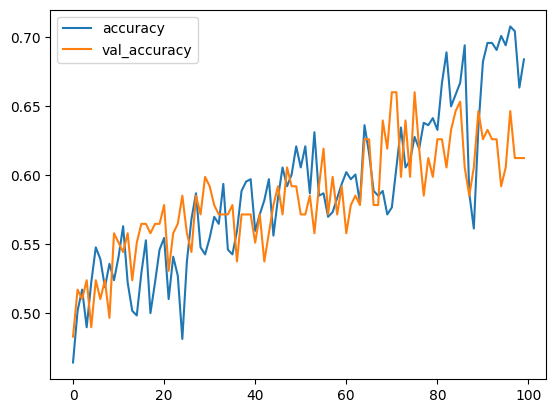

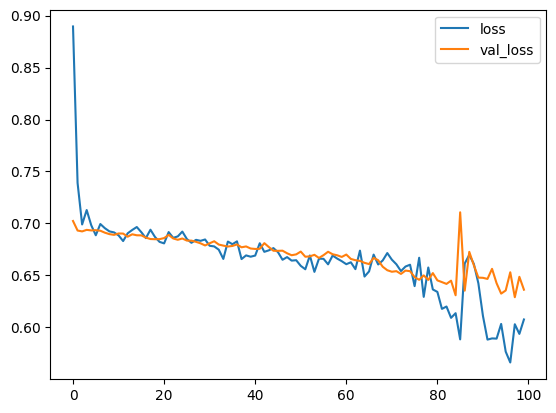

In [17]:

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()